In [1]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 6.0 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import pyod

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
folder_path = '/kaggle/input/cicids2017'
file_list = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
merged_df = pd.concat([pd.read_csv(os.path.join(folder_path, file)) for file in file_list], ignore_index = True)
merged_df.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
merged_df.shape

(2830743, 79)

In [6]:
merged_df.columns = merged_df.columns.str.strip().str.upper().str.replace(' ', '_')
merged_df.columns

Index(['DESTINATION_PORT', 'FLOW_DURATION', 'TOTAL_FWD_PACKETS',
       'TOTAL_BACKWARD_PACKETS', 'TOTAL_LENGTH_OF_FWD_PACKETS',
       'TOTAL_LENGTH_OF_BWD_PACKETS', 'FWD_PACKET_LENGTH_MAX',
       'FWD_PACKET_LENGTH_MIN', 'FWD_PACKET_LENGTH_MEAN',
       'FWD_PACKET_LENGTH_STD', 'BWD_PACKET_LENGTH_MAX',
       'BWD_PACKET_LENGTH_MIN', 'BWD_PACKET_LENGTH_MEAN',
       'BWD_PACKET_LENGTH_STD', 'FLOW_BYTES/S', 'FLOW_PACKETS/S',
       'FLOW_IAT_MEAN', 'FLOW_IAT_STD', 'FLOW_IAT_MAX', 'FLOW_IAT_MIN',
       'FWD_IAT_TOTAL', 'FWD_IAT_MEAN', 'FWD_IAT_STD', 'FWD_IAT_MAX',
       'FWD_IAT_MIN', 'BWD_IAT_TOTAL', 'BWD_IAT_MEAN', 'BWD_IAT_STD',
       'BWD_IAT_MAX', 'BWD_IAT_MIN', 'FWD_PSH_FLAGS', 'BWD_PSH_FLAGS',
       'FWD_URG_FLAGS', 'BWD_URG_FLAGS', 'FWD_HEADER_LENGTH',
       'BWD_HEADER_LENGTH', 'FWD_PACKETS/S', 'BWD_PACKETS/S',
       'MIN_PACKET_LENGTH', 'MAX_PACKET_LENGTH', 'PACKET_LENGTH_MEAN',
       'PACKET_LENGTH_STD', 'PACKET_LENGTH_VARIANCE', 'FIN_FLAG_COUNT',
       'SYN_FLAG_CO

In [7]:
merged_df.drop('FWD_HEADER_LENGTH.1', axis = 1, inplace = True)

In [8]:
merged_df[['FLOW_BYTES/S', 'FLOW_PACKETS/S']] = merged_df[['FLOW_BYTES/S', 'FLOW_PACKETS/S']].replace([np.inf, -np.inf], np.nan)
merged_df[['FLOW_BYTES/S', 'FLOW_PACKETS/S']] = merged_df[['FLOW_BYTES/S', 'FLOW_PACKETS/S']].fillna(merged_df[['FLOW_BYTES/S', 'FLOW_PACKETS/S']].median())

In [9]:
merged_df['ANOMALY'] = merged_df['LABEL'].apply(lambda s: 0 if s == "BENIGN" else 1)
y = merged_df['ANOMALY'].values

In [10]:
feature_cols = [c for c in merged_df.columns 
                if c not in ('LABEL', 'ANOMALY')]
X = merged_df[feature_cols].copy()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.30,
    stratify = y,
    random_state = 42
)

In [19]:
label_counts = merged_df['LABEL'].value_counts()
label_counts

LABEL
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

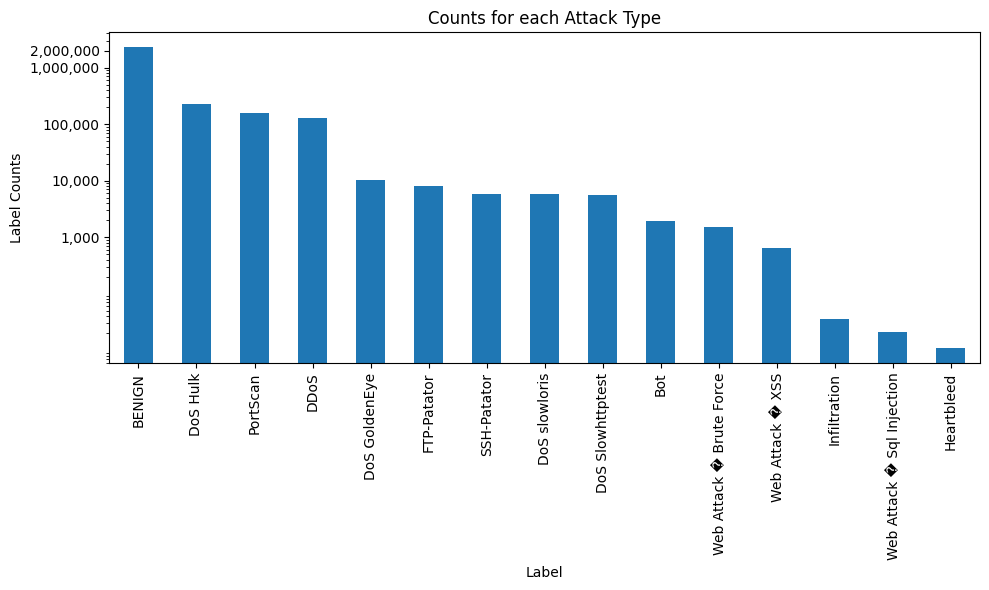

In [21]:
label_counts = merged_df['LABEL'].value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Label Counts')
plt.title('Counts for each Attack Type')

plt.yscale('log')


yticks = [1e3, 1e4, 1e5, 1e6, 2e6]
plt.yticks(yticks, [f"{int(y):,}" for y in yticks])

plt.xticks(rotation = 90)

plt.tight_layout()
plt.show()

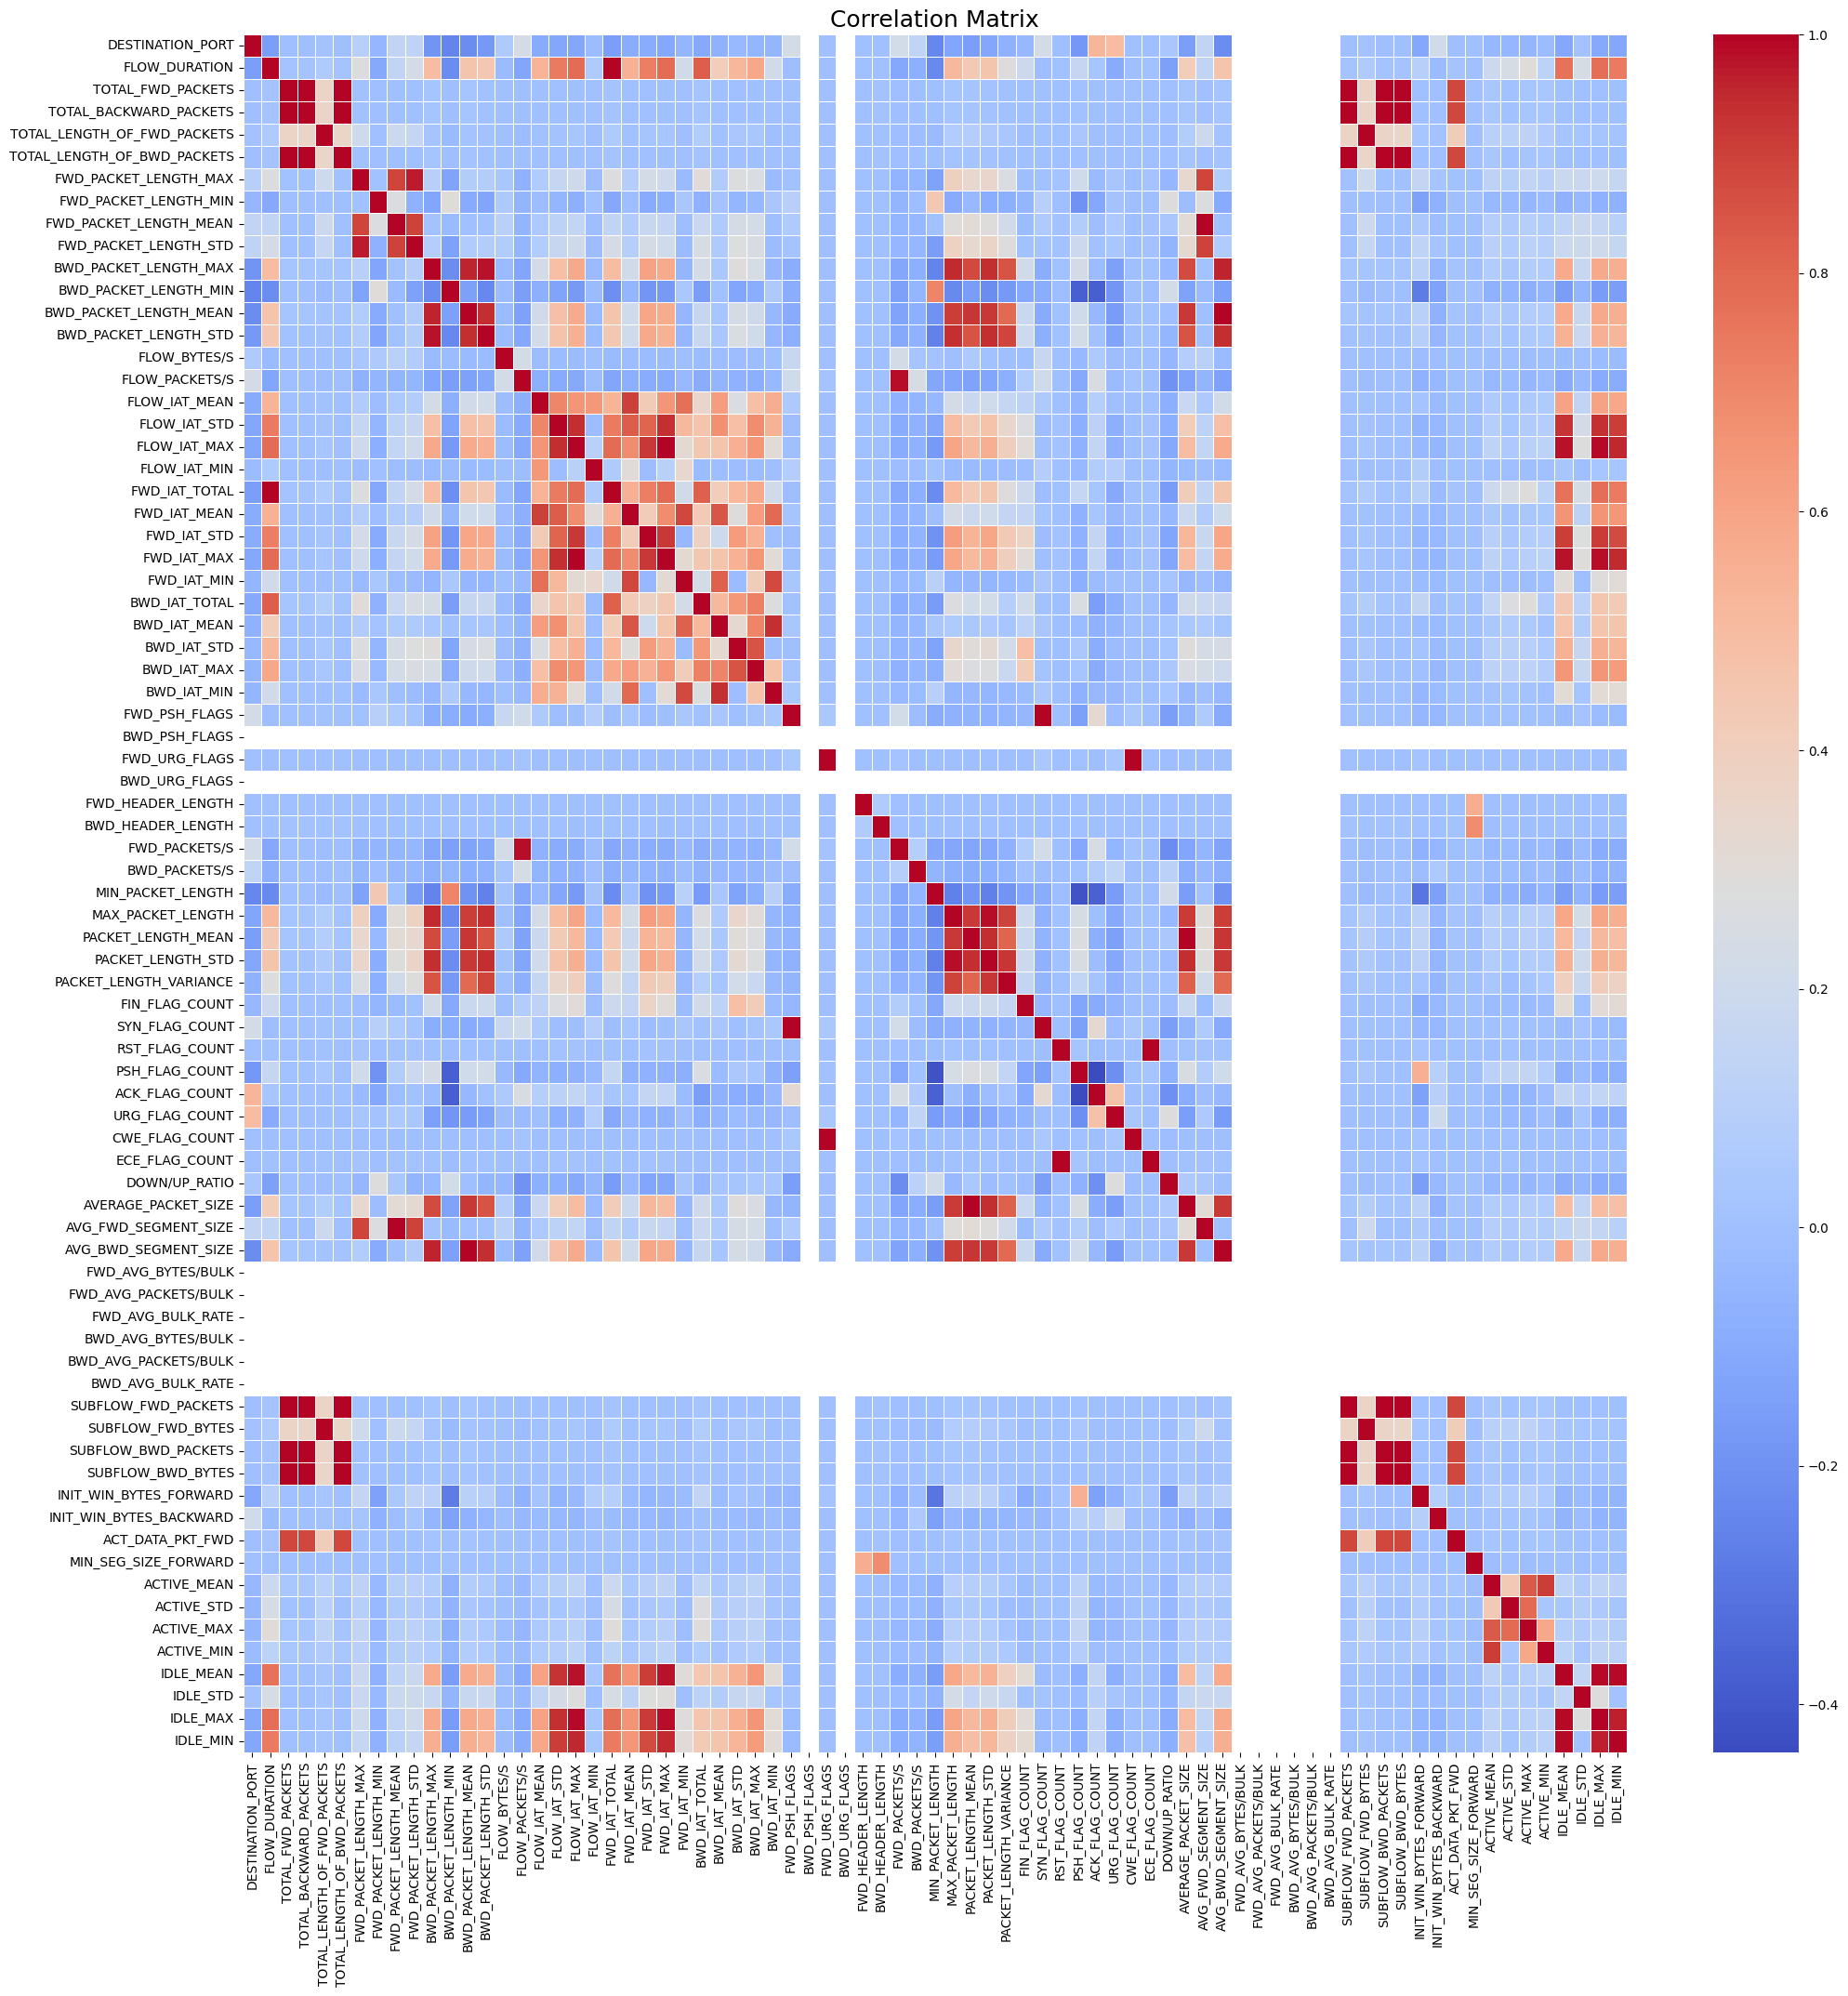

In [13]:
corr_matrix = X.corr()

fig, ax = plt.subplots(figsize = (24, 24))
sns.heatmap(corr_matrix, cmap = 'coolwarm', annot = False, linewidth = 0.5)
plt.title('Correlation Matrix', fontsize = 18)
plt.show()

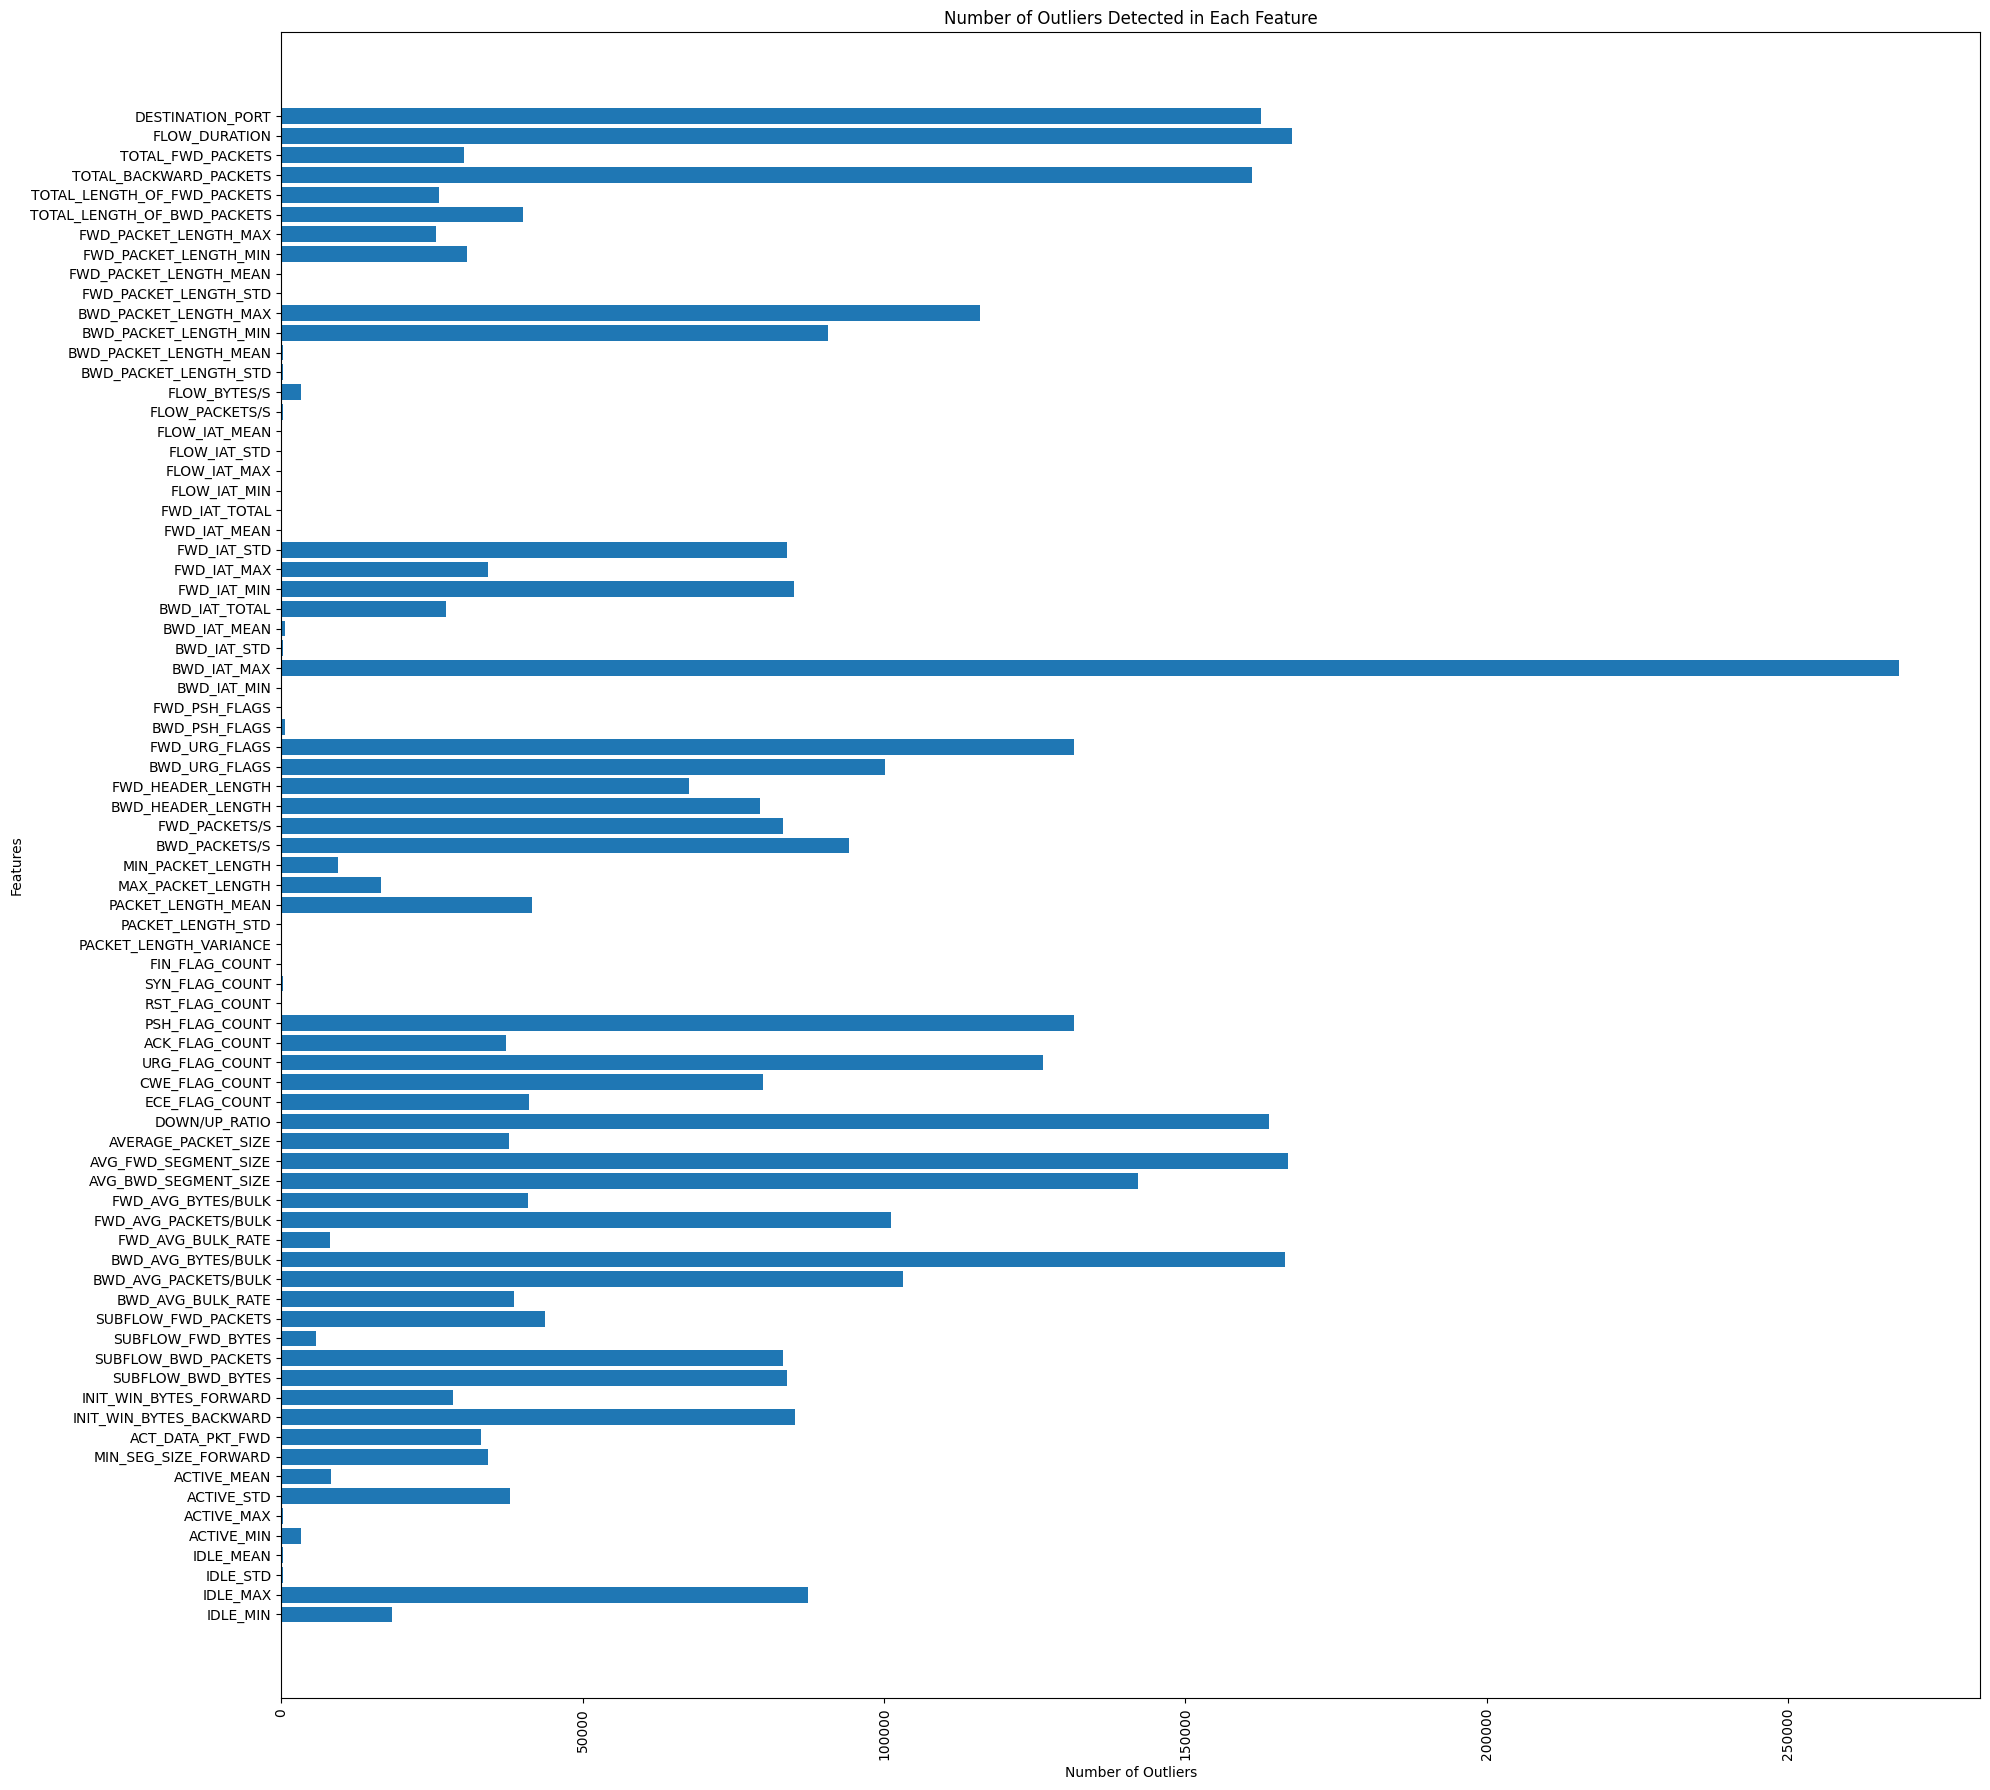

In [14]:
outlier_counts = {}

for column in X.columns:
    mean = X[column].mean()
    std = X[column].std()
    z_scores = (X[column] - mean) / std
    outliers = np.abs(z_scores) > 3
    outlier_counts[column] = np.sum(outliers)

features = X.columns.tolist()
outlier_values = list(outlier_counts.values())

plt.figure(figsize = (20, 18))
plt.barh(features[::-1], outlier_values)
plt.xlabel('Number of Outliers')
plt.ylabel('Features')
plt.title('Number of Outliers Detected in Each Feature')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

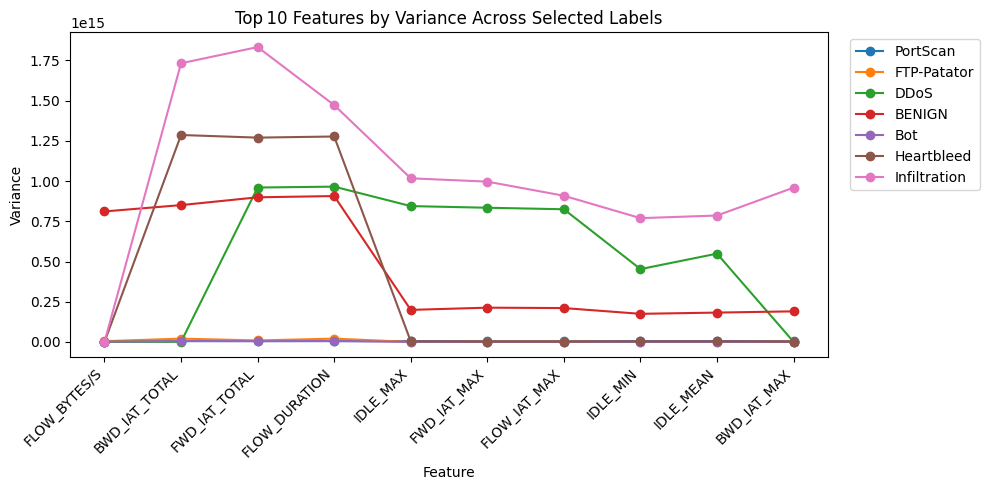

In [15]:
df_train = X_train.copy()
df_train['LABEL'] = merged_df['LABEL']

labels_of_interest = ['PortScan', 'FTP-Patator', 'DDoS', 'BENIGN', 'Bot', 'Heartbleed', 'Infiltration']

var_by_label = df_train.groupby('LABEL').var()

var_range = var_by_label.max() - var_by_label.min()
top10_feats = var_range.sort_values(ascending = False).head(10).index.tolist()

plt.figure(figsize = (10,5))
for lbl in labels_of_interest:
    plt.plot(top10_feats,
             var_by_label.loc[lbl, top10_feats],
             marker = 'o',
             label = lbl)

plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.title('Top 10 Features by Variance Across Selected Labels')
plt.legend(bbox_to_anchor = (1.02,1), loc = 'upper left')
plt.tight_layout()
plt.show()

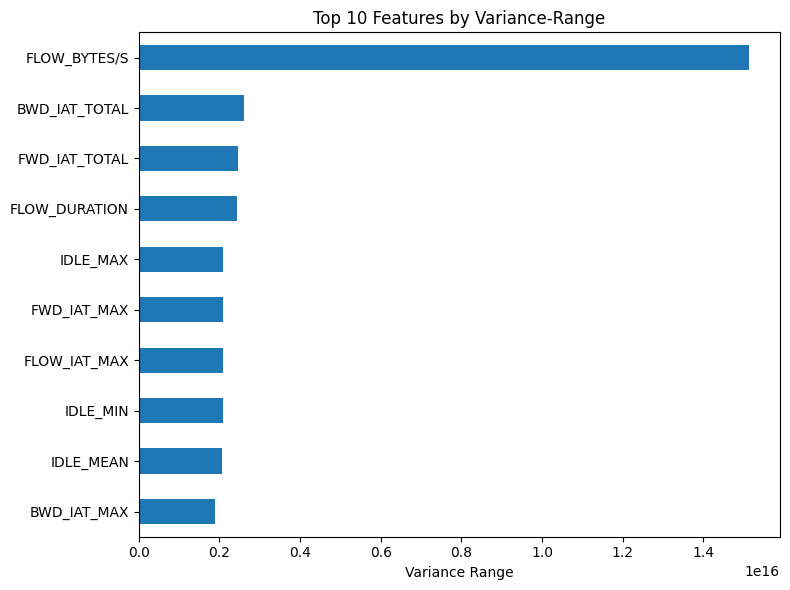

In [16]:
df_train = X_train.copy()
df_train['LABEL'] = merged_df['LABEL']

var_by_label = df_train.groupby('LABEL').var()

var_range = var_by_label.max(axis = 0) - var_by_label.min(axis = 0)
top10 = var_range.nlargest(10).sort_values()

top10.plot(kind = 'barh', figsize = (8,6), title = "Top 10 Features by Variance‐Range")
plt.xlabel("Variance Range")
plt.tight_layout()
plt.show()

In [17]:
def profile_dataset_and_assign_tags(X, y):
    n_samples, n_features = X.shape
    anomaly_ratio = np.mean(y)
    missing_ratio = X.isna().sum().sum() / (n_samples * n_features)

    skewness = stats.skew(X, axis = 0, nan_policy = "omit")
    kurtosis = stats.kurtosis(X, axis = 0, nan_policy = "omit")
    avg_skewness = np.nanmean(np.abs(skewness))
    avg_kurtosis = np.nanmean(np.abs(kurtosis))

    tags = []

    # Dimensionality
    if n_features <= 10:
        tags.append("low_dimensional")
    elif n_features <= 100:
        tags.append("medium_dimensional")
    else:
        tags.append("high_dimensional")

    # Sample Size
    if n_samples <= 500:
        tags.append("small_sample")
    elif n_samples <= 5000:
        tags.append("medium_sample")
    else:
        tags.append("large_sample")

    # Imbalance
    if anomaly_ratio < 0.05:
        tags.append("highly_imbalanced")
    elif anomaly_ratio < 0.20:
        tags.append("imbalanced")
    else:
        tags.append("balanced")

    # Noise Estimation
    if avg_skewness > 2.5 or avg_kurtosis > 10:
        tags.append("noisy")
    else:
        tags.append("low_noise")

    # Missing Data
    if missing_ratio > 0.1:
        tags.append("missing_data")

    # Structure assumption (tabular)
    tags.append("structured_data")

    # Build summary table
    metrics_df = pd.DataFrame({
        "Metric": [
            "n_samples", "n_features", "anomaly_ratio",
            "missing_value_ratio", "avg_skewness", "avg_kurtosis"
        ],
        "Value": [
            n_samples, n_features, round(anomaly_ratio, 6),
            round(missing_ratio, 6), round(avg_skewness, 4),
            round(avg_kurtosis, 4)
        ]
    })

    print("Dataset Profiling Summary")
    display(metrics_df)

    print("\n Assigned Tags:", tags)
    return tags, metrics_df

In [18]:
assigned_tags, metrics_df = profile_dataset_and_assign_tags(X_train, y_train)

all_dataset_results = []

all_dataset_results.append({
    "name": "CICIDS2017.csv",
    "tags": assigned_tags,
    "metrics": metrics_df.to_dict(orient = "records")
})

Dataset Profiling Summary


,Metric,Value
0,n_samples,1.981520e+06
1,n_features,7.700000e+01
2,anomaly_ratio,1.969960e-01
3,missing_value_ratio,0.000000e+00
4,avg_skewness,9.245560e+01
5,avg_kurtosis,6.195412e+04



 Assigned Tags: ['medium_dimensional', 'large_sample', 'imbalanced', 'noisy', 'structured_data']


In [ ]:
# 1) Define your detectors here (add or remove as you like)
from pyod.models.iforest      import IForest
from pyod.models.lof          import LOF
from pyod.models.knn          import KNN
from pyod.models.ocsvm        import OCSVM
from pyod.models.copod        import COPOD

detectors = {
    "IForest" : IForest(contamination=np.mean(y_train)),
    "LOF"     : LOF(contamination=np.mean(y_train)),
    "KNN"     : KNN(contamination=np.mean(y_train)),
    "OCSVM"   : OCSVM(contamination=np.mean(y_train)),
    "COPOD"   : COPOD(contamination=np.mean(y_train))
}

# 2) Scale your features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 3) Fit each detector, get its “outlier score” on X_test, and compute ROC-AUC
roc_scores = {}
for name, clf in detectors.items():
    clf.fit(X_train_scaled)
    # PyOD’s decision_function gives higher = more anomalous
    scores_test = clf.decision_function(X_test_scaled)
    roc_scores[name] = roc_auc_score(y_test, scores_test)

# 4) Turn into a Series, sort, and plot
roc_series = pd.Series(roc_scores).sort_values()

plt.figure(figsize=(8,5))
roc_series.plot(kind='barh')
plt.title("PyOD Detectors: ROC AUC on CICIDS2017")
plt.xlabel("ROC AUC")
plt.xlim(0.5, 1.0)         # anomalies are binary; 0.5 is random
plt.tight_layout()
plt.show()